# Heart Disease Prediction

Following a current trend in clinical diagnosis, where machine learning is applied to medical data in order to predict health conditions, this notebook shows a first approach to solving such problem.

The notebook is divided into two main sections:
1. Medical context and data summary
2. Data characterization
    * Data visualization
3. Classification models
    * Random Forest
    * SVM
    * Multilayer Perceptron

At the end, a summary and conclusion is presented.

Dataset was extracted from https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive on February 21st, 2021.

## Medical Context and Data Summary

The data used contains clinical information regarding a series of patients, namely:
* Age
* Sex
* Type of chest pain
* Resting blood pressure
* Serum cholesterol
* Fasting blood sugar
* Electrocardiogram (ECG) results
* Heart rate
* Presence of heart disease

What some of these mean is already known to us - age, sex, heart rate, presence of heart disease, blood pressure, cholesterol, blood sugar - the remaining ones are described below.

### Type of Chest Pain

Chest pains in this data set are described as one of the following four categories:
1. Typical angina
2. Atypical angina
3. Non-anginal pain
4. Asymptomatic (i.e. no pain)

As such to comprehend the categories, we need to define angina [1]:

> **Angina:**  
_Chest pain caused by reduced blood flow to the heart muscles._

This can be further differentiated in _typical_ and _atypical_ anginas:

> **Typical angina:**  
_Episodes with a trigier (such as stress or exercisce) that stop within a few minutes of resting._  
**Atypical angina:**  
_Episodes may not have a trigger and can continue despite resting._

### Electrocardiogram segments

Some of the features in the data relate to specific information in ECG results, a schematic of such is seen in Fig. 1.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/1024px-SinusRhythmLabels.svg.png" width="400">
<center>Fig. 1 - Schematic of a regular ECG</center>

Information on the dataset pertains to ST-T wave abnormalities, Estes' criteria, slope of the ST segment and the ST depression induced by exercise relative to rest [2]. Definitions relevant to the dataset used are described below.

> **De/Repolarization:**  
_Changes in the polarization of the cell's membrane potential._  

> **ST Segment:**  
_Represents the period when the ventricles are depolarized._  
> **T Wave:**  
_Represents repolarization of the ventricles._  

> **Estes' Criteria:**  
_Set of criteria to determine the probability of Left Ventricular Hypertrophy._  


### Problem Statement

With all the data available, the question if there is any underlying pattern concerning heart diseases and if it can be used for predictions rises. This problem has been tackled before in literature [3, 4]. Here a first approach to answering that question is presented. For this, three different machine learning models are attempted:
* Random Forest
* SVM (linear, polynomial, RBF and sigmoid kernels)
* Multilayer Perceptron

## Data Characterization and Visualization

In this section, exploration of the dataset is presented with accompanying visualizations and (when appliable) statistical metrics. A sample of the dataset is shown below.

In [468]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, f1_score, plot_confusion_matrix

In [469]:
filename = "heart_statlog_cleveland_hungary_final.csv"
df = pd.read_csv(filename)
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [542]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

Following the documentation provided with the dataset:

Numerical attributes (units between square brackets):  
* age \[year\]  
* resting bp s (resting blood pressure) \[mm Hg\]  
* cholesterol (serum cholesterol) \[mg/dL\]
* max heart rate (maximum heart rate achieved) \[bpm\]
* oldpeak (ST depression) - units not given

Categorical attributes:
* sex  
    0 = Female  
    1 = Male  
* chest pain type  
    1 = Typical angina  
    2 = Atypical angina  
    3 = Non-anginal pain  
    4 = Asymptomatic
* fasting blood sugar  
    0 = Fasting blood sugar < 120 mg/dL  
    1 = Fasting blood sugar > 120 mg/dL
* resting ecg  
    0 = Normal  
    1 = ST-T wave abnormality  
    2 = Probable/Definite left ventricular hypertrophy by Estes' criteria
* exercise angina  
    0 = No exercise induced angina  
    1 = Exercise induced agina
* ST slope  
    1 = Positive slope  
    2 = Flat  
    3 = Negative slope
* class  
    0 = No heart disease  
    1 = Heart disease
    
For the numerical categories, a table with common univariate statistical metrics is shown below.

In [543]:
numerical_df = df[["age", "resting bp s", "cholesterol", "max heart rate", "oldpeak"]]
numerical_df.describe()

,age,resting bp s,cholesterol,max heart rate,oldpeak
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,132.153782,210.363866,139.732773,0.922773
std,9.358203,18.368823,101.420489,25.517636,1.086337
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,188.000000,121.000000,0.000000
50%,54.000000,130.000000,229.000000,140.500000,0.600000
75%,60.000000,140.000000,269.750000,160.000000,1.600000
max,77.000000,200.000000,603.000000,202.000000,6.200000


### Visualizing the Data

To better understand the contents of the data used, plotting it can be more useful than simply showing a table. 

In [470]:
colors_class = ["#D7E8FF", "#EF2D1B"]
colors_gender = ["#F5BCFA", "#AEEAF5"]
colors_fbs = ["#ff0000", "#00ff00"]

In [471]:
def get_col_value_counts(pandaSeries, category_dict):
    count = pandaSeries.value_counts(sort=False)

    for cat_key in category_dict.keys():
        count[category_dict[cat_key]] = count.pop(cat_key)

    values = [v for v in count]
    labels = count.keys()
    return values, labels

In [472]:
def build_barh(pandasSeries, catDict, title=""):
    values, labels = get_col_value_counts(pandasSeries, catDict)
    ymin = min(catDict.keys())
    ymax=max(catDict.keys())+1
    y_coord = range(ymin,ymax)
    plt.title(title)
    plt.barh(y=y_coord, width=values, tick_label=labels)

In [521]:
def build_pie(pandaSeries, catDict, title="", colors=colors_class,labels=True):
    values, labels_count = get_col_value_counts(pandaSeries, catDict)

    if labels == False:
        labels_count = None
    
    plt.pie(values,labels=labels_count,autopct='%1.1f%%', colors=colors)
    plt.title(title)
    plt.axis('equal')

#### class

The attribute used to distinguish if an individual has or not a heart diseas

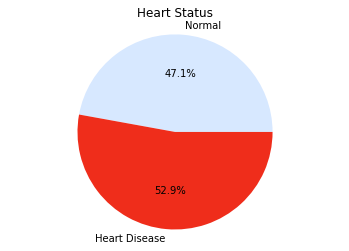

In [522]:
category_dict = {0: "Normal", 
                 1: "Heart Disease"}
build_pie(df["target"], category_dict, title="Heart Status")
plt.show()

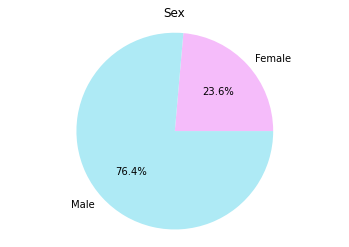

In [523]:
gender_dict = {0: "Female", 
                 1: "Male"}

build_pie(df["sex"], gender_dict, title="Sex", colors=colors_gender)

plt.show()

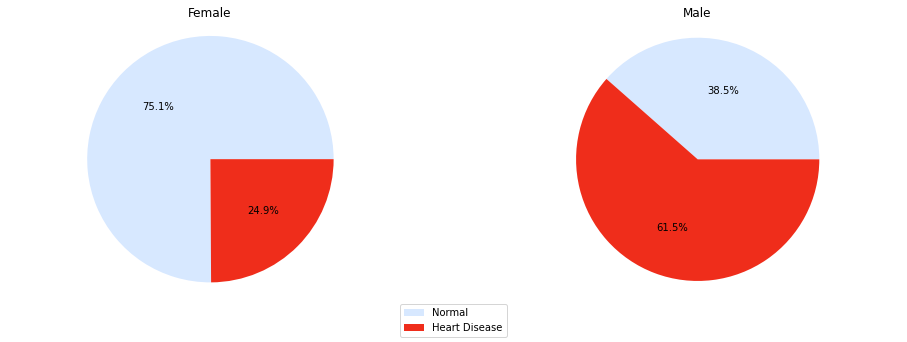

In [540]:
female_df = df[df["sex"] == 0]
male_df = df[df["sex"] == 1]

category_dict = {0: "Normal", 
                 1: "Heart Disease"}

_, labels = get_col_value_counts(female_df["target"], category_dict)

fig = plt.figure(figsize=(16, 5))

plt.subplot(1,2,1)
build_pie(female_df["target"], category_dict, title="Female", labels=False)

plt.subplot(1,2,2)
build_pie(male_df["target"], category_dict, title="Male", labels=False)

fig.legend(labels=labels, loc=8)

plt.show()

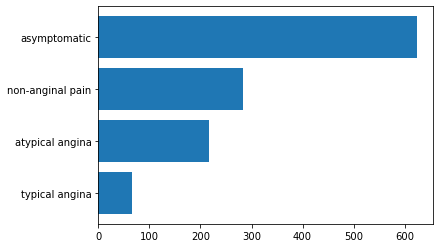

In [525]:
pain_dict = {1: "typical angina",
                2: "atypical angina",
                3: "non-anginal pain",
                4: "asymptomatic"}

build_barh(df["chest pain type"], pain_dict)

plt.show()

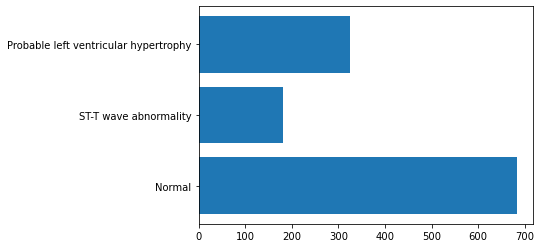

In [526]:
ecg_dict = {0: "Normal",
                1: "ST-T wave abnormality",
                2: "Probable left ventricular hypertrophy"}

build_barh(df["resting ecg"], ecg_dict)

plt.show()

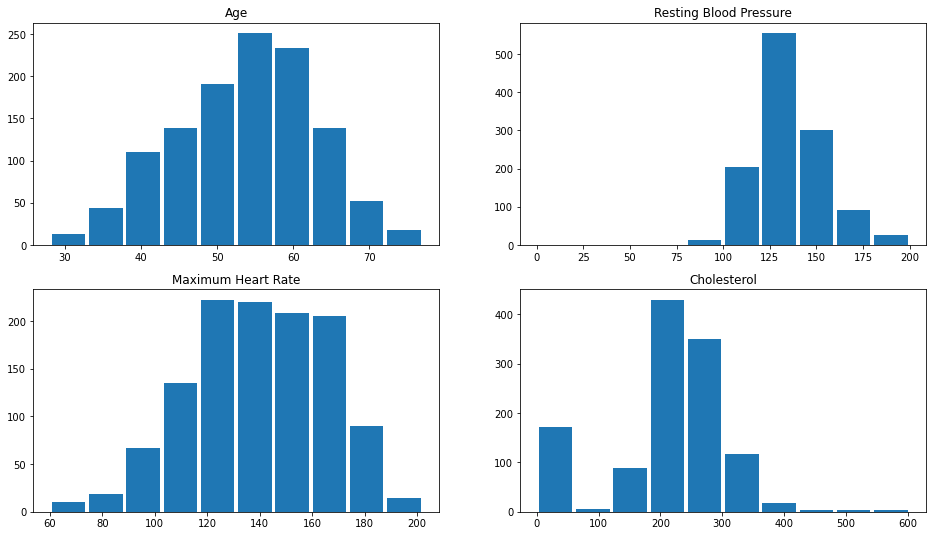

In [527]:
plt.figure(figsize=(16,9))

plt.subplot(221)
plt.hist(df["age"], rwidth=0.9)
plt.title("Age")

plt.subplot(222)
plt.hist(df["resting bp s"], rwidth=0.9)
plt.title("Resting Blood Pressure")

plt.subplot(223)
plt.hist(df["max heart rate"], rwidth=0.9)
plt.title("Maximum Heart Rate")

plt.subplot(224)
plt.hist(df["cholesterol"], rwidth=0.9)
plt.title("Cholesterol")

plt.show()

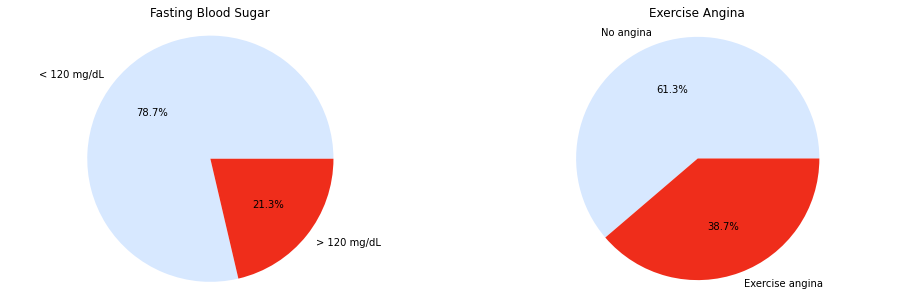

In [528]:
plt.figure(figsize=(16,5))

sugar_dict = {0: "< 120 mg/dL", 
                 1: "> 120 mg/dL"}
plt.subplot(121)
build_pie(df["fasting blood sugar"], sugar_dict, title="Fasting Blood Sugar")

exercise_dict = {0: "No angina", 
                 1: "Exercise angina"}
plt.subplot(122)
build_pie(df["exercise angina"], exercise_dict, title="Exercise Angina")

plt.show()

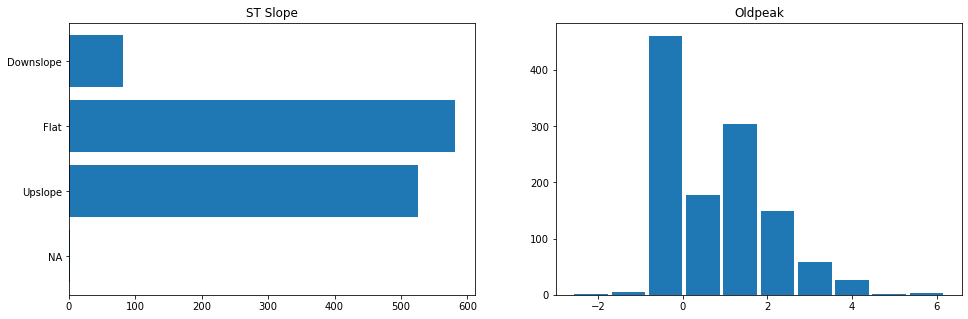

In [529]:
plt.figure(figsize=(16,5))

slope_dict = {0: "NA",
                1: "Upslope",
                2: "Flat",
                3: "Downslope"}

plt.subplot(121)
build_barh(df["ST slope"], slope_dict, title="ST Slope")

plt.subplot(122)
plt.hist(df["oldpeak"], rwidth=0.9)
plt.title("Oldpeak")

plt.show()

# Predicting Heart Disease

## Preparing data

In [530]:
features = df.drop("target", axis=1)

features["sex"].replace(gender_dict, inplace=True)
features["chest pain type"].replace(pain_dict, inplace=True)
features["fasting blood sugar"].replace(sugar_dict, inplace=True)
features["resting ecg"].replace(ecg_dict, inplace=True)
features["exercise angina"].replace(exercise_dict, inplace=True)
features["ST slope"].replace(slope_dict, inplace=True)

display(df.head())
display(features.head())

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,40,Male,atypical angina,140,289,< 120 mg/dL,Normal,172,No angina,0.0,Upslope
1,49,Female,non-anginal pain,160,180,< 120 mg/dL,Normal,156,No angina,1.0,Flat
2,37,Male,atypical angina,130,283,< 120 mg/dL,ST-T wave abnormality,98,No angina,0.0,Upslope
3,48,Female,asymptomatic,138,214,< 120 mg/dL,Normal,108,Exercise angina,1.5,Flat
4,54,Male,non-anginal pain,150,195,< 120 mg/dL,Normal,122,No angina,0.0,Upslope


In [531]:
features = pd.get_dummies(features)

features.head()

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex_Female,sex_Male,chest pain type_asymptomatic,chest pain type_atypical angina,chest pain type_non-anginal pain,...,fasting blood sugar_> 120 mg/dL,resting ecg_Normal,resting ecg_Probable left ventricular hypertrophy,resting ecg_ST-T wave abnormality,exercise angina_Exercise angina,exercise angina_No angina,ST slope_Downslope,ST slope_Flat,ST slope_NA,ST slope_Upslope
0,40,140,289,172,0.0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,49,160,180,156,1.0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
2,37,130,283,98,0.0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1
3,48,138,214,108,1.5,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,54,150,195,122,0.0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [532]:
targets = np.array(df["target"])
feature_list = list(features.columns)
features = np.array(features)

In [533]:
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size=0.3)

## Random Forest

In [534]:
rf = RandomForestRegressor(n_estimators=10000)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=10000)

In [535]:
score = rf.predict(test_features)
ap = average_precision_score(test_labels, score)
ap = ap*100
print("Average precision: %0.2f%%" % ap)

Average precision: 95.09%


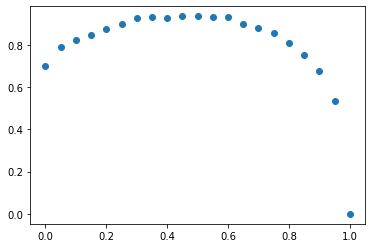

Maximum F1-score is 0.94 at a threshold level of 0.45


In [536]:
threshold = []
f1 = []
for t in range(0, 105, 5):
    results = [1 if s >= (t/100) else 0 for s in score]
    threshold.append(t/100)
    f1.append(f1_score(test_labels, results))
    
plt.scatter(threshold, f1)
plt.show()

opt_threshold = threshold[f1.index(max(f1))]
print("Maximum F1-score is %0.2f at a threshold level of %0.2f" % (max(f1), opt_threshold))

results = [1 if s >= opt_threshold else 0 for s in score]

## SVM

In [537]:
kernel_list = ["linear", "poly", "rbf", "sigmoid"]
max_degree = 10

for kernel in kernel_list:
    svm_clf = svm.SVC(kernel=kernel)
    svm_clf = svm.SVC(kernel=kernel)
    svm_clf.fit(train_features, train_labels)
    pred = svm_clf.predict(test_features)
    print("Using %s kernel,\n\tF1-score: %0.2f" % (kernel,f1_score(test_labels, pred)))

    ap = average_precision_score(test_labels, pred)
    ap = ap*100
    print("\tAverage precision: %0.2f%%" % ap)

Using linear kernel,
	F1-score: 0.88
	Average precision: 82.52%
Using poly kernel,
	F1-score: 0.73
	Average precision: 66.26%
Using rbf kernel,
	F1-score: 0.72
	Average precision: 67.89%
Using sigmoid kernel,
	F1-score: 0.56
	Average precision: 54.39%


## Neural Network

In [538]:
mlp_clf = MLPClassifier(solver="sgd", alpha=1e-5, hidden_layer_sizes=(1000,900))
mlp_clf.fit(train_features, train_labels)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(1000, 900), solver='sgd')

In [539]:
mlp_pred = mlp_clf.predict(test_features)

print("F1-score: %0.2f" % f1_score(test_labels, mlp_pred))
#print("\tAverage precision: %0.2f%%" % average_precision_score(test_labels, mlp_pred)*100)

F1-score: 0.66


## References

[1] https://www.nhs.uk/conditions/angina/  
[2] https://archive.ics.uci.edu/ml/datasets/heart%2BDisease  
[3] S. Benbelkacem and B. Atmani, "Random Forests for Diabetes Diagnosis," _2019 International Conference on Computer and Information Sciences (ICCIS)_, Sakaka, Saudi Arabia, 2019, pp. 1-4, doi: 10.1109/ICCISci.2019.8716405  
[4] Birjais, R., Mourya, A.K., Chauhan, R. _et al._ Prediction and diagnosis of future diabetes risk: a machine learning approach. _SN Appl. Sci._ 1, 1112 (2019). https://doi.org/10.1007/s42452-019-1117-9  